<div style="display: flex;">
    <a href="https://t.me/nsbarsukov" style="margin-right:20px;">
        <img src="https://img.shields.io/badge/Telegram-2CA5E0?style=for-the-badge&logo=telegram&logoColor=white" alt="write-me-telegram"/>
    </a>
    <a href="https://github.com/nsbarsukov/toxic-comments-detector" style="margin-right:20px;">
        <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="Open Github"/>
    </a>
</div>
<div style="display: flex; margin-top: 20px;">
    <a href="https://colab.research.google.com/github/nsbarsukov/toxic-comments-detector/blob/master/models/04weightedRNN%2BNavec.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
</div>

In [1]:
import os

def check_is_google_colab():
    return 'google.colab' in str(get_ipython())


def prepare_environment():
    if check_is_google_colab():
        from google.colab import drive
        import shutil
        
        drive.mount('/content/gdrive/')

        PATH_TO_TEMP_REPO = '/content/gdrive/My Drive/toxic-comments-repo-temp'

        try:
            shutil.rmtree(PATH_TO_TEMP_REPO)
        except:
            pass

        os.mkdir(PATH_TO_TEMP_REPO)
        
        %cd ./gdrive/My Drive/toxic-comments-repo-temp
        ! git clone https://github.com/nsbarsukov/toxic-comments-detector.git .
        ! pip3 install -q tensorflow_text navec
    else:
        %cd ..

prepare_environment()

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    get_class_weights,
    get_initial_output_bias,
    evaluate_model,
    make_sentence_vectorizer,
    get_3d_quartile_words_count,
    SEED,
    VALIDATION_SPLIT_PARTITION,
    DEFAULT_BATCH_SIZE,
    DEFAULT_EPOCHS,
)
from wordEmbeddingsLayers import get_navec_word_vectorizer

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Word Vectorizer

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [4]:
VECTORIZED_SENTENCE_LENTGH = get_3d_quartile_words_count(X_train.flatten())

navec_word_vectorizer, NAVEC_EMBEDDING_DIMENSION = get_navec_word_vectorizer()

navec_sentence_vectorizer = make_sentence_vectorizer(
    vectorizer=navec_word_vectorizer,
    pad_sentence_to_n_words=VECTORIZED_SENTENCE_LENTGH
)

In [5]:
X_train = np.array(list(
    map(navec_sentence_vectorizer, X_train.flatten())
))

X_test = np.array(list(
    map(navec_sentence_vectorizer, X_test.flatten())
))

# Build RNN model

In [6]:
from tensorflow.keras import layers, losses

negative_class_amount, pos_class_amount = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    get_initial_output_bias(pos_class_amount, negative_class_amount)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,
    verbose=1,
    restore_best_weights=False
)

model = tf.keras.Sequential([
    layers.Input(shape=(VECTORIZED_SENTENCE_LENTGH, NAVEC_EMBEDDING_DIMENSION,), dtype=tf.float32),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    
    tf.keras.layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.5, seed=SEED),
    layers.Dense(units=1, bias_initializer=initial_output_bias),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), # from_logits=False, т.к. на выходе layers.Activation('sigmoid')
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [7]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH_SIZE,
    validation_split=VALIDATION_SPLIT_PARTITION,
    callbacks=[early_stopping],
    class_weight=get_class_weights(pos_class_amount, negative_class_amount),
)

Epoch 1/10
19/19 [==============================] - 34s 1s/step - loss: 0.6350 - binary_accuracy: 0.7058 - recall: 0.3621 - precision: 0.5677 - val_loss: 0.3580 - val_binary_accuracy: 0.8621 - val_recall: 0.7214 - val_precision: 0.8419
Epoch 2/10
19/19 [==============================] - 15s 824ms/step - loss: 0.3863 - binary_accuracy: 0.8550 - recall: 0.7560 - precision: 0.8070 - val_loss: 0.3330 - val_binary_accuracy: 0.8625 - val_recall: 0.8659 - val_precision: 0.7565
Epoch 3/10
19/19 [==============================] - 17s 899ms/step - loss: 0.3091 - binary_accuracy: 0.8746 - recall: 0.8820 - precision: 0.7747 - val_loss: 0.4526 - val_binary_accuracy: 0.8001 - val_recall: 0.9531 - val_precision: 0.6327
Epoch 4/10
19/19 [==============================] - 17s 908ms/step - loss: 0.3447 - binary_accuracy: 0.8407 - recall: 0.8986 - precision: 0.7158 - val_loss: 0.3271 - val_binary_accuracy: 0.8799 - val_recall: 0.8190 - val_precision: 0.8201
Epoch 5/10
19/19 [=============================

# Model evaluation

Accuracy: 90.67%
Recall: 90.36%
Precision: 82.96%
F1-score: 86.5% 



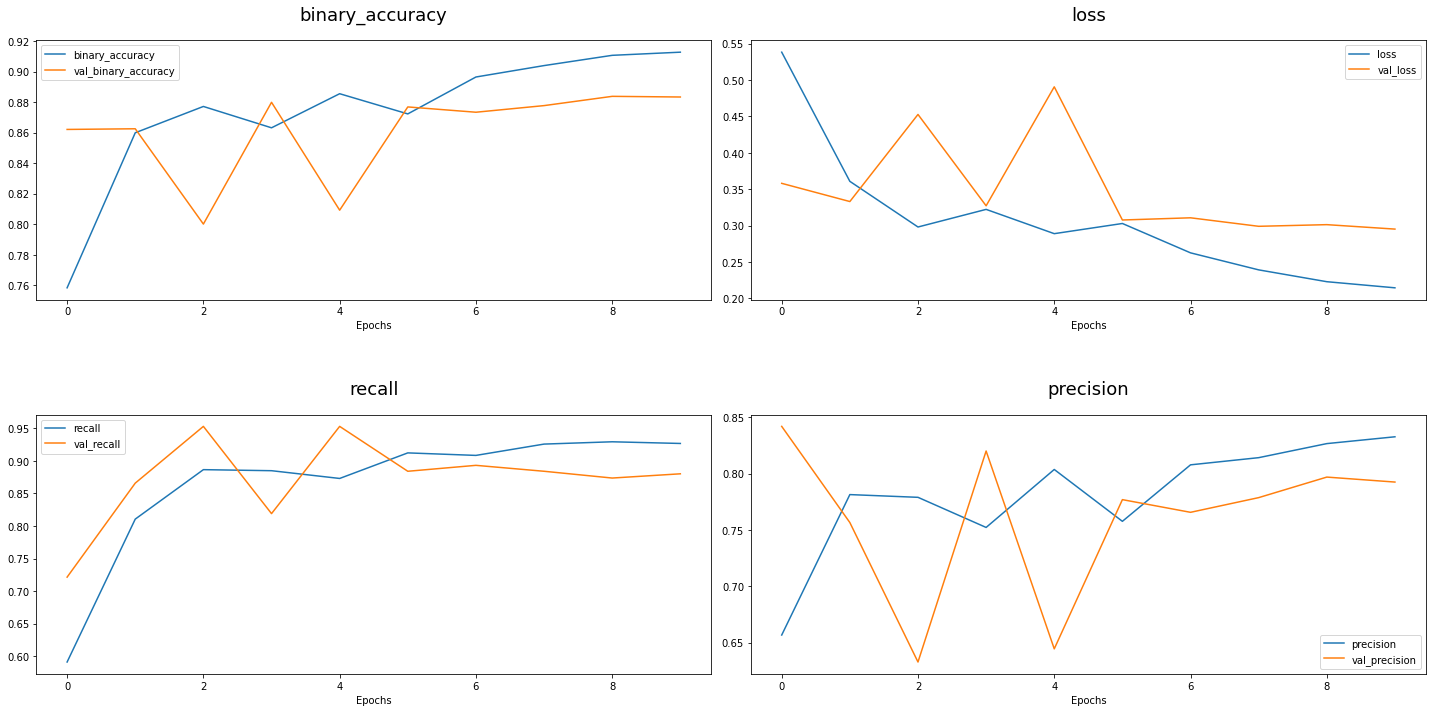

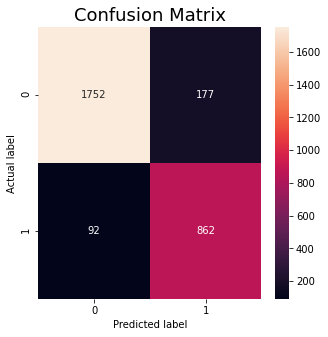

In [8]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)